In [10]:
# Computing and applying a linear minimum-norm inverse method on evoked/raw/epochs data

# Import necessary libraries and functions
from mne.minimum_norm import apply_inverse_epochs
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.datasets import sample, eegbci, fetch_fsaverage
import mne
import matplotlib.pyplot as plt
import os
import os.path as op
import numpy as np
import matplotlib
import pyvista
pyvista.set_jupyter_backend('trame')
%matplotlib inline


Using pyvistaqt 3d backend.

0 files missing from root.txt in /home/prakhar7/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/prakhar7/mne_data/MNE-fsaverage-data/fsaverage
Reading /home/prakhar7/mfprl/neuroconn/src/../data/in/101_epoched.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Using notebook 3d backend.

Source space          : /home/prakhar7/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /home/prakhar7/.conda/envs/main2/lib/python3.10/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : ins

/tmp/ipykernel_2238617/1259402395.py:26: RuntimeWarning: This filename (../data/in/101_epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epoched_file)
/tmp/ipykernel_2238617/1259402395.py:38: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Source spaces are now in head coordinates.

Setting up the BEM model using /home/prakhar7/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif...

Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /home/prakhar7/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Employing the head->MRI coordinate transform with the BEM model.
BEM model fsaverage-5120-5120-5120-bem-sol.fif is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 10242 points...
    Found  2433/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 7809 points outside using surface Qhull
    Found     0/ 7809 points outside using solid angles
    Total 10242/102

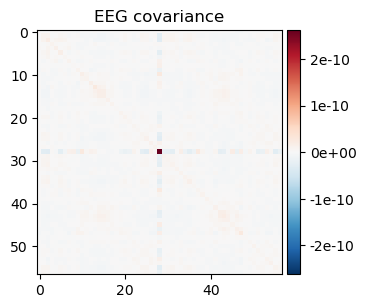

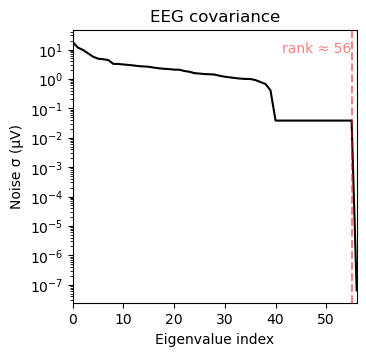

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


/tmp/ipykernel_2238617/1259402395.py:117: RuntimeWarning: This filename (../data/out/101_forwardsolution_MRItemplate.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  mne.write_forward_solution(forward_solution_file, fwd, overwrite=True)
/tmp/ipykernel_2238617/1259402395.py:117: RuntimeWarning: This forward solution is based on a forward solution with free orientation. The original forward solution is stored on disk in X/Y/Z RAS coordinates. Any transformation (surface orientation or fixed orientation) will be reverted. To reapply any transformation to the forward operator please apply convert_forward_solution after reading the forward solution with read_forward_solution.
  mne.write_forward_solution(forward_solution_file, fwd, overwrite=True)


In [16]:
#matplotlib.use('Qt5Agg')  # Setting the backend BEFORE importing pyplot

mne.viz.set_3d_backend("pyvista")

#################################################################################
# Adult template MRI (fsaverage)

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")
bem = op.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")

#################################################################################

# Process EEG data

# Load epoched data
output_dir = r'../data/in'  # Replace with your desired output directory
subj = '101'  # --> replace participant ID here
epoched_file = os.path.join(output_dir, subj + '_epoched.fif')
epochs = mne.read_epochs(epoched_file)

# List of channels to drop
channels_to_drop = ['LHEye', 'RHEye', 'Lneck', 'Rneck', 'RVEye', 'FPz']

# Drop the channels from the epochs data
epochs.drop_channels(channels_to_drop)

# Adjust EEG electrode locations to match the fsaverage template, which are already in fsaverage's
# # space (MNI space) for standard_1020
montage_path = r"../data/in/MFPRL_UPDATED_V2.sfp"
montage = mne.channels.read_custom_montage(montage_path)
epochs.set_montage(montage)
epochs.set_eeg_reference(projection=True)  # needed for inverse modeling

# Set the 3D backend to pyvista
mne.viz.set_3d_backend('notebook')

# Check that the locations of EEG electrodes is correct with respect to MRI
# mne.viz.plot_alignment(
#     epochs.info,
#     src=src,
#     eeg=["original", "projected"],
#     trans=trans,
#     show_axes=True,
#     mri_fiducials=True,
#     dig="fiducials",
# )

# Compute the forward solution using the fsaverage template
fwd = mne.make_forward_solution(
    epochs.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None
)

# Adjusting picks to EEG data
picks = mne.pick_types(epochs.info, meg=False, eeg=True, eog=True, stim=False)

# Compute regularized noise covariance
noise_cov = mne.compute_covariance(
    epochs, tmax=0.0, method=["shrunk", "empirical"], rank=None, verbose=True
)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, epochs.info)

#################################################################################
# Visualize the source space on the cortex

# Read the forward solution
mne.convert_forward_solution(fwd, surf_ori=True, copy=False)

# Extract the source space information from the forward solution
lh = fwd["src"][0]  # Visualize the left hemisphere
verts = lh["rr"]  # The vertices of the source space
tris = lh["tris"]  # Groups of three vertices that form triangles
dip_pos = lh["rr"][lh["vertno"]]  # The position of the dipoles
dip_ori = lh["nn"][lh["vertno"]]
dip_len = len(dip_pos)
dip_times = [0]

# Create a Dipole instance
actual_amp = np.ones(dip_len)  # misc amp to create Dipole instance
actual_gof = np.ones(dip_len)  # misc GOF to create Dipole instance
dipoles = mne.Dipole(dip_times, dip_pos, actual_amp, dip_ori, actual_gof)
trans = trans

# Create a new 3D figure and plot red dots at the dipole locations (run all code below at once)
# fig = mne.viz.create_3d_figure(size=(600, 400))
# mne.viz.plot_alignment(  # Plot the cortical surface on the figure
#     subject=subject,
#     subjects_dir=subjects_dir,
#     trans=trans,
#     surfaces="white",
#     coord_frame="mri",
#     fig=fig,
# )
# mne.viz.plot_dipole_locations(  # Plot the dipoles on the same figure
#     dipoles=dipoles,
#     trans=trans,
#     mode="sphere",
#     subject=subject,
#     subjects_dir=subjects_dir,
#     coord_frame="mri",
#     scale=7e-4,
#     fig=fig,
# )
# mne.viz.set_3d_view(figure=fig, azimuth=180, distance=0.25)  # Adjust the view

# Save the computed forward solution to a .fif file
output_dir = r'../data/out'  # Replace with your desired output directory
forward_solution_file = os.path.join(
    output_dir, subj + '_forwardsolution_MRItemplate.fif')
mne.write_forward_solution(forward_solution_file, fwd, overwrite=True)


In [17]:
#################################################################################
# Inverse modeling: eLORETA on evoked data with dipole orientation discarded (pick_ori="None"), only magnitude kept


# Create a loose-orientation inverse operator, with depth weighting
inv = make_inverse_operator(
    epochs.info, fwd, noise_cov, fixed=False, loose=0.2, depth=0.8, verbose=True)

# Compute eLORETA solution for each epoch
snr = 3.0
lambda2 = 1.0 / snr**2
# pick_ori="None" --> Discard dipole orientation, only keep magnitude
stcs = apply_inverse_epochs(
    epochs, inv, lambda2, "eLORETA", verbose=True, pick_ori=None)

Computing inverse operator with 57 channels.
    57 out of 57 channels remain after picking
Selected 57 channels
Creating the depth weighting matrix...
    57 EEG channels
    limit = 20485/20484 = 2.125736
    scale = 134832 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 4.1e-14 (2.2e-16 eps * 57 dim * 3.2  max singular value)
    Estimated rank (eeg): 56
    EEG: rank 56 computed from 57 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 5.87821
    scaling factor to adjust the trace = 1.11176e+24 (nchan = 57 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 t

In [18]:
# Average the source estimates across epochs
stc_avg = sum(stcs) / len(stcs)

# Get the time of the peak magnitude
print(stcs[0])
_, time_max = stc_avg.magnitude().get_peak(hemi="lh")

# Visualization parameters
kwargs = dict(
    hemi="lh",
    subjects_dir=subjects_dir,
    size=(600, 600),
    clim=dict(kind="percent", lims=[90, 95, 99]),
    smoothing_steps=7,
    time_unit="s",
    initial_time=time_max  # Set the initial_time to the time of the peak magnitude
)

# Visualizing the averaged source estimate with dipole magnitude
brain_magnitude = stc_avg.plot(**kwargs)
mne.viz.set_3d_view(figure=brain_magnitude, focalpoint=(0.0, 0.0, 50))

# Average the data across all source space points
avg_data = stc_avg.data.mean(axis=(0, 1))

# Plot the average data as a function of time
fig, ax = plt.subplots()
ax.plot(1e3 * stc_avg.times, avg_data)
ax.set(xlabel="time (ms)", ylabel="eLORETA value (average)")
plt.show()


print('Saving file')
# Save the inverse solution data
output_dir = r'../data/out'  # Replace with your desired output directory
for idx, stc in enumerate(stcs):
    inverse_solution_file = os.path.join(
        output_dir, f"{subj}_inversesolution_epoch{idx}.fif")
    stc.save(inverse_solution_file, overwrite=True)


<SourceEstimate | 20484 vertices, subject : fsaverage, tmin : -500.0 (ms), tmax : 500.0 (ms), tstep : 1.953125 (ms), data shape : (20484, 513), ~80.3 MB>


AttributeError: 'SourceEstimate' object has no attribute 'magnitude'